# PCA on wine quality data
We like this data, because it is all numeric data.
It looks like this

```
"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;9.8;5
```

Check data in *datasets/wine-quality*
- winequality-red.csv
- winequality-white.csv

In [1]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /Users/sujee/spark
Spark config:
	 spark.app.name=TestApp
	spark.master=local[*]
	executor.memory=2g
	spark.sql.warehouse.dir=/var/folders/lp/qm_skljd2hl4xtps5vw0tdgm0000gn/T/tmp0emx_rem
	some_property=some_value
Spark UI running on port 4040


In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import PCA

## Step 1 : Load Data

In [3]:
## read data
data_file= '/data/wine-quality/winequality-red.csv'
#data_file= '/data/wine-quality/winequality-white.csv'
column_to_remove = 'quality'


t1 = time.perf_counter()

data = spark.read.\
          option('header', 'true').\
          option('inferSchema', 'true').\
          option('delimiter', ';').\
          csv(data_file)
t2 = time.perf_counter()
print("read {:,} records in {:,.2f} ms".format(data.count(), (t2-t1)*1000))

data_clean = data.na.drop()
print("raw data count {},  cleaned data count {}".format(data.count(), data_clean.count()))

data_clean.show()

read 1,599 records in 3,409.29 ms
raw data count 1599,  cleaned data count 1599
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|     

## Step 2 : Basic data analysis

In [4]:
## remove columns we don't need
columns = data_clean.columns
columns.remove(column_to_remove)  # this is the target , so remove
data2 = data_clean.select(columns)

print("original data columns  ", len(data2.columns))
data2.show()

original data columns   11
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|                60.0|  0.998|3.1

In [5]:
## basic data analytics
data2.describe().show()

+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+
|summary|     fixed acidity|   volatile acidity|        citric acid|    residual sugar|           chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|         sulphates|           alcohol|
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+
|  count|              1599|               1599|               1599|              1599|                1599|               1599|                1599|                1599|               1599|              1599|              1599|
|   mean| 8.319637273295838| 0.5278205128205131| 0.2709756097560964|2.53880550343965

## Step 3 : Create feature vector

In [6]:
assembler = VectorAssembler(inputCols=columns, outputCol="features")
feature_vector = assembler.transform(data2)
feature_vector.select('features').show(10, False)

+--------------------------------------------------------+
|features                                                |
+--------------------------------------------------------+
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |
|[7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8]  |
|[7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8] |
|[11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8]|
|[7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4]  |
|[7.4,0.66,0.0,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4] |
|[7.9,0.6,0.06,1.6,0.069,15.0,59.0,0.9964,3.3,0.46,9.4]  |
|[7.3,0.65,0.0,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0]|
|[7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5] |
|[7.5,0.5,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.8,10.5]|
+--------------------------------------------------------+
only showing top 10 rows



## Step 4 : Correlation Matrix of original data
Do see any correlation?

In [7]:
corr1 = Correlation.corr(feature_vector, "features").head()
pearson_corr = corr1[0]
#print("Pearson correlation matrix:\n" + str(pearson_corr))

## convert to numpy for pretty print
print("Pearson correlation matrix")
np.set_printoptions(precision=2,  linewidth=200)
pearson_corr_nparr = pearson_corr.toArray()
print(pearson_corr_nparr)

## convert to pandas for even prettier print :-)
names = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides",\
         "free sulfur dioxide","total sulfur dioxide","density","pH", "sulphates","alcohol"]

df = pd.DataFrame(pearson_corr_nparr, index=names, columns=names)
df

Pearson correlation matrix
[[ 1.   -0.26  0.67  0.11  0.09 -0.15 -0.11  0.67 -0.68  0.18 -0.06]
 [-0.26  1.   -0.55  0.    0.06 -0.01  0.08  0.02  0.23 -0.26 -0.2 ]
 [ 0.67 -0.55  1.    0.14  0.2  -0.06  0.04  0.36 -0.54  0.31  0.11]
 [ 0.11  0.    0.14  1.    0.06  0.19  0.2   0.36 -0.09  0.01  0.04]
 [ 0.09  0.06  0.2   0.06  1.    0.01  0.05  0.2  -0.27  0.37 -0.22]
 [-0.15 -0.01 -0.06  0.19  0.01  1.    0.67 -0.02  0.07  0.05 -0.07]
 [-0.11  0.08  0.04  0.2   0.05  0.67  1.    0.07 -0.07  0.04 -0.21]
 [ 0.67  0.02  0.36  0.36  0.2  -0.02  0.07  1.   -0.34  0.15 -0.5 ]
 [-0.68  0.23 -0.54 -0.09 -0.27  0.07 -0.07 -0.34  1.   -0.2   0.21]
 [ 0.18 -0.26  0.31  0.01  0.37  0.05  0.04  0.15 -0.2   1.    0.09]
 [-0.06 -0.2   0.11  0.04 -0.22 -0.07 -0.21 -0.5   0.21  0.09  1.  ]]


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595


## Step 5 : Scale Data
We need to scale data before PCA

In [8]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scaler_model = scaler.fit(feature_vector)

# Normalize each feature to have unit standard deviation.
fv_scaled = scaler_model.transform(feature_vector)
fv_scaled.select('features', 'scaledFeatures').show()

+--------------------+--------------------+
|            features|      scaledFeatures|
+--------------------+--------------------+
|[7.4,0.7,0.0,1.9,...|[4.25019565141442...|
|[7.8,0.88,0.0,2.6...|[4.47993595689628...|
|[7.8,0.76,0.04,2....|[4.47993595689628...|
|[11.2,0.28,0.56,1...|[6.43272855349210...|
|[7.4,0.7,0.0,1.9,...|[4.25019565141442...|
|[7.4,0.66,0.0,1.8...|[4.25019565141442...|
|[7.9,0.6,0.06,1.6...|[4.53737103326675...|
|[7.3,0.65,0.0,1.2...|[4.19276057504396...|
|[7.8,0.58,0.02,2....|[4.47993595689628...|
|[7.5,0.5,0.36,6.1...|[4.30763072778489...|
|[6.7,0.58,0.08,1....|[3.84815011682117...|
|[7.5,0.5,0.36,6.1...|[4.30763072778489...|
|[5.6,0.615,0.0,1....|[3.21636427674605...|
|[7.8,0.61,0.29,1....|[4.47993595689628...|
|[8.9,0.62,0.18,3....|[5.11172179697140...|
|[8.9,0.62,0.19,3....|[5.11172179697140...|
|[8.5,0.28,0.56,1....|[4.88198149148954...|
|[8.1,0.56,0.28,1....|[4.65224118600768...|
|[7.4,0.59,0.08,4....|[4.25019565141442...|
|[7.9,0.32,0.51,1....|[4.5373710

## Step 6 : Do PCA

In [9]:
# numver of principal components 
num_pc = 5

pca = PCA(k=num_pc, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(fv_scaled)
pca_features = model.transform(fv_scaled).select("pcaFeatures")
pca_features.select('pcaFeatures').show(10, False)

+-------------------------------------------------------------------------------------------------+
|pcaFeatures                                                                                      |
+-------------------------------------------------------------------------------------------------+
|[-200.52300795572555,122.44884946888742,174.2706688449383,-91.7742344126466,-94.45713884332292]  |
|[-201.34311133731194,123.85401284326744,173.40817468697605,-91.27006647632277,-94.3717595114335] |
|[-201.39378632623794,122.87980341782519,173.6677975288843,-91.40706891699864,-94.34662792813798] |
|[-204.4989666207256,121.72814883292513,172.2533571000047,-92.7461206590126,-92.89146510366653]   |
|[-200.52300795572555,122.44884946888742,174.2706688449383,-91.7742344126466,-94.45713884332292]  |
|[-200.55881935859696,122.56705728042496,174.03457460823253,-91.79421858454909,-94.28010377659146]|
|[-201.04091178323517,122.60586525463768,173.57234795585248,-92.16181267988007,-93.25711741765575]|


## Step 7 : Correlation Matrix for Principal Components
These should be very small (close to zero!)

In [10]:
## correlation matrix for PC
## should be very close to zero
corr_pc = Correlation.corr(pca_features, "pcaFeatures").head()[0]
corr_pc_nparr = corr_pc.toArray()

print ("Correlation Matrtix for Principal Components")
np.set_printoptions(precision=2, suppress=False)
print(corr_pc_nparr)
print()

print ("Correlation Matrtix for Principal Components")
np.set_printoptions(precision=2, suppress=True)
print(corr_pc_nparr)

Correlation Matrtix for Principal Components
[[ 1.00e+00  3.42e-11  4.98e-11 -5.63e-12  6.33e-12]
 [ 3.42e-11  1.00e+00 -8.42e-11  1.67e-11  1.34e-12]
 [ 4.98e-11 -8.42e-11  1.00e+00  5.30e-11  5.22e-11]
 [-5.63e-12  1.67e-11  5.30e-11  1.00e+00 -1.85e-11]
 [ 6.33e-12  1.34e-12  5.22e-11 -1.85e-11  1.00e+00]]

Correlation Matrtix for Principal Components
[[ 1.  0.  0. -0.  0.]
 [ 0.  1. -0.  0.  0.]
 [ 0. -0.  1.  0.  0.]
 [-0.  0.  0.  1. -0.]
 [ 0.  0.  0. -0.  1.]]


## Step 8 : Calculate PC Variance

We started with 5 PCs.  
How much coverage (variance) are we getting?

Play with **num_pc** in Step-6 to get 90% coverage


In [11]:
## variance
variance = model.explainedVariance.toArray()
print(variance)
print ("Original data had {} features,  principal components {}".format(len(data2.columns), num_pc))
print("Cumulative Explained Variance: " + str(np.cumsum(variance)[-1]))

[0.28 0.18 0.14 0.11 0.09]
Original data had 11 features,  principal components 5
Cumulative Explained Variance: 0.7952827473412729


## Step 9 : Screeplot
Screeplot goes from 0.0  to 1.0

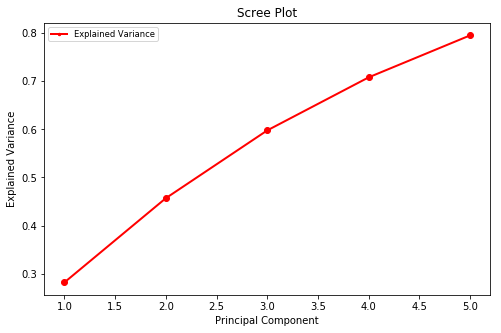

In [12]:
variance = model.explainedVariance.toArray()
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(num_pc) + 1
plt.plot(np.arange(num_pc) + 1, np.cumsum(variance), 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')


leg = plt.legend(['Explained Variance'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)